In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install torch
import torch

# VAE kernels
Can we use VAE as a kernel for convolutional layer? The idea is that for each receptive field, VAE would find multinomial gaussian distribution shared across all instances of the receptive field. The resulting system would have features, feature value ranges and distributions at each receptive field, similar to neurons with various feature value preferences for each receptive field in the cortex. For example, a neuron may have a preference for horizontal lines, upward movement, slow speed movement. That would be equivalent to VAE finding 3 features with specific values for a given receptive field. A neuron can have preference for only one (or few) values of a given feature so a lot of neurons are needed to represent the domain of each feature with sufficient statistical redundency. But a VAE's output for a given receptive field, e.g. 0.3 for feature 1, 0.9 for feature 2 and 0.5 for feature 3 with low, high and medium variance, respectively, can represent 1000s of feature-value preferences and 100s of neurons (because a neuron can be selective to a different value for each feature). The similifying factor here is Laplace assumption. Maybe using an order of magnitude more # of features would result at least in mixture of gaussians because a feature would get duplicated and learn different modes of the distribution.

## Basics

In [0]:
import logging
import numpy as np
import random
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.basicConfig(
    level=logging.ERROR,
    format='%(asctime)s.%(msecs)03d %(name)s:%(funcName)s %(levelname)s:%(message)s',
    datefmt="%M:%S")

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from skimage.draw import line_aa
%matplotlib inline
plt.style.use('classic')

def show_image(image, vmin=None, vmax=None, title=None, print_values=False, figsize=(4, 4)):
  #print("image ", image.shape)
  image = image.cpu().numpy()
  fig, ax1 = plt.subplots(figsize=figsize)
  if title:
    plt.title(title)
  #i = image.reshape((height, width))
  #print("i ", i.shape)
  ax1.imshow(image, vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma)
  plt.show()
  if print_values:
    print(image)

def generate_bouncing_pixel(width, height, count=100):
  ball_width = 2
  x = 3 #random.randint(0, width)
  y = 2 #random.randint(0, height)
  dx = -1 #random.randint(0, 2) - 1
  dy = 1 #random.randint(0, 2) - 1
  
  images = []
  for _ in range(count):
    image = np.zeros((width, height))
    image[x, y] = 1.0
    image[x+1, y] = 1.0
    image[x, y+1] = 1.0
    image[x+1, y+1] = 1.0

    #image=gaussian_filter(image, 0.5)
    images.append(image)
    x += dx
    y += dy
    if (x < 0 or x > width - 1 - (ball_width - 1)):
      dx *= -1
      x += dx
    if (y < 0 or y > height - 1 - (ball_width - 1)):
      dy *= -1
      y += dy

  return torch.as_tensor(images)

## Network


In [0]:
class VAE(nn.Module):
  def __init__(self, input_width, input_height, feature_count):
    super(VAE, self).__init__()
    self.logger = logging.getLogger(self.__class__.__name__)
    self.logger.setLevel(logging.WARN)

    self.feature_count = feature_count

    self.encoder = nn.Sequential(
      nn.Linear(input_width * input_height    , input_width * input_height * 2),
      #nn.BatchNorm1d(1),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(input_width * input_height * 2, input_width * input_height * 4),
      #nn.BatchNorm1d(1),
      nn.LeakyReLU(0.2, inplace=True),
    )

#     self.e_l1 = nn.Linear(input_width * input_height    , input_width * input_height * 2)
#     self.e_b1 = nn.BatchNorm1d(1)
#     self.e_r1 = nn.LeakyReLU(0.2, inplace=True)
#     self.e_l2 = nn.Linear(input_width * input_height * 2, input_width * input_height * 4)
#     self.e_b2 = nn.BatchNorm1d(1)
#     self.e_r2 = nn.LeakyReLU(0.2, inplace=True)
      
    self.decoder = nn.Sequential(
      nn.Linear(feature_count  , input_width * input_height * 2),
      #nn.BatchNorm1d(1),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(input_width * input_height * 2, input_width * input_height),
      #nn.BatchNorm2d(1),
      nn.Sigmoid(),
    )

    self.linear_mu = nn.Linear(input_width * input_height * 4, feature_count)
    self.linear_sigma = nn.Linear(input_width * input_height * 4, feature_count)

    self.lrelu = nn.LeakyReLU()
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()

  def encode(self, x):
    self.logger.debug(f"x {x.shape}")
    x = self.encoder(x)
#     x = self.e_l1(x)
#     #x = self.e_b1(x)
#     x = self.e_r1(x)
#     x = self.e_l2(x)
#     #x = self.e_b2(x)
#     x = self.e_r2(x)
    
    #return self.tanh(self.linear_mu(x)), self.tanh(self.linear_sigma(x))
    return self.sigmoid(self.linear_mu(x)), self.linear_sigma(x)

  def decode(self, z):
    #z = z.view(-1, 1, 1, self.feature_count)
    self.logger.debug(f"z {z.shape}")
    return self.decoder(z)

  def reparametrize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    eps = torch.FloatTensor(std.size()).normal_().to(device)
    eps = eps.mul(std).add_(mu)
    eps = torch.sigmoid(eps)
    self.logger.debug(f"eps {eps.shape}")

    return eps

  def decode_features(self, mu, logvar):
    z = self.reparametrize(mu, logvar)
    self.logger.debug(f"z {z.shape}")
    decoded = self.decode(z)
    self.logger.debug(f"decoded {decoded.shape}")
    return decoded, z

    
  def forward(self, x):
    self.logger.debug(f"x {x.shape}")
    mu, logvar = self.encode(x)
    self.logger.debug(f"mu {mu.shape}")
    self.logger.debug(f"logvar {logvar.shape}")
    
    decoded, z = self.decode_features(mu, logvar)
    return decoded, mu, logvar, z
  
  
class Network(nn.Module):
  def __init__(self, input_width, input_height, feature_count):
    super(Network, self).__init__()
    self.input_width = input_width
    self.input_height = input_height
    self.vae = VAE(input_width, input_height, feature_count)
    
  def forward(self, x):
    return self.vae(x)

  def loss_function(self, recon_x, x, mu, logvar):
    # print(recon_x.size(), x.size())
    BCE = F.binary_cross_entropy(recon_x.view(-1, self.input_width * self.input_height), x.view(-1, self.input_width * self.input_height), size_average=False)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # return BCE + KLD
    BCE /= 0.00001
    #print(BCE, KLD)
    return BCE + KLD
  
  def train(self, input, num_epochs=3000):
    learning_rate = 10e-3
    optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate,
                                 weight_decay=1e-5)

    done = False
    epoch = 0
    while not done:
      output, mu, logvar, z = self(input)
      loss = self.loss_function(output, input, mu, logvar)
      # ===================backward====================
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if epoch % int(num_epochs / 10) == 0:
        print('epoch [{}/{}], loss:{:.4f}'
             .format(epoch+1, num_epochs, loss.item()))
        show_image(output[0].view(self.input_height, self.input_width).detach(), title=f"output {0}", vmin=0, vmax=1)

      if (loss.item() < 0.001 and epoch > 1500) or epoch > num_epochs:
        done = True

      epoch += 1
      torch.save(self.state_dict(), self.save_path())

    return output, mu, logvar, z

  def save_path(self):
    return f"network.pt"




## Example

torch.Size([2880, 25])


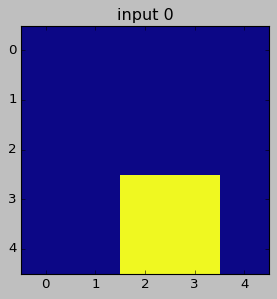

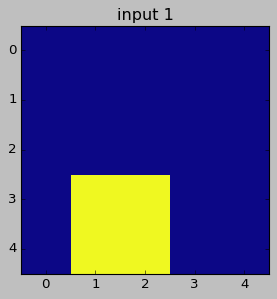

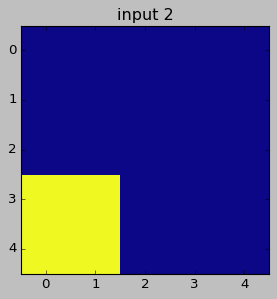

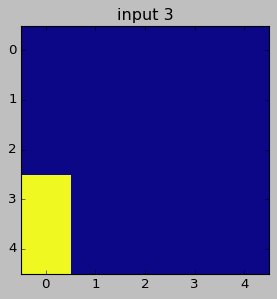

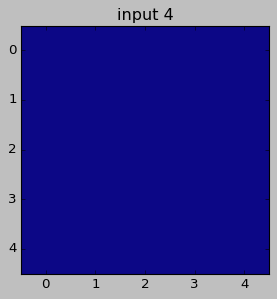

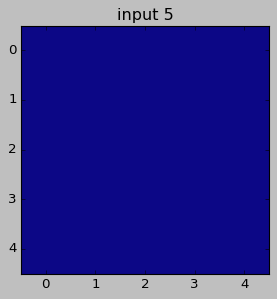

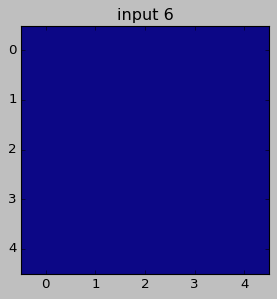

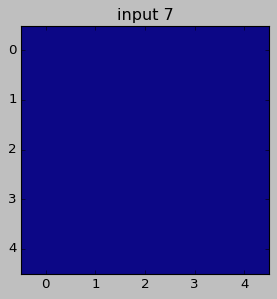

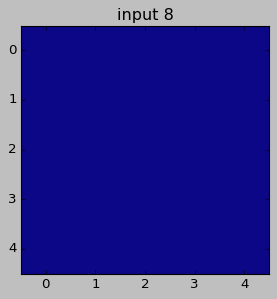

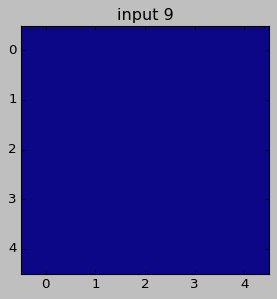

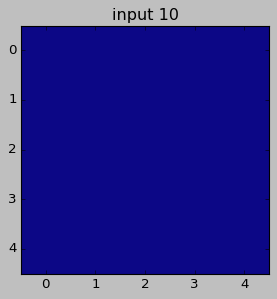

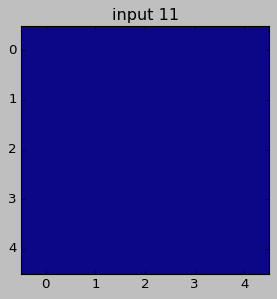

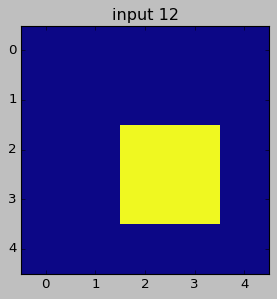

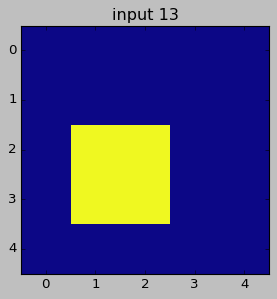

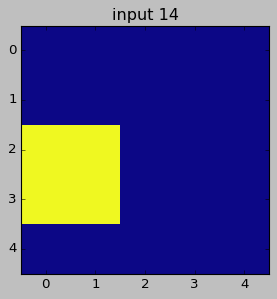

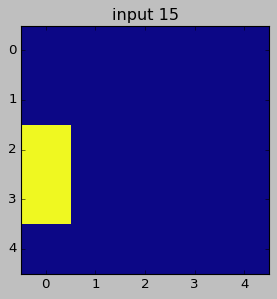

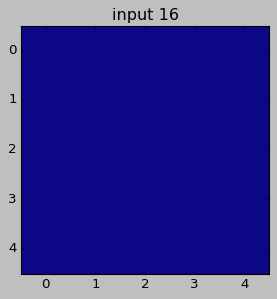

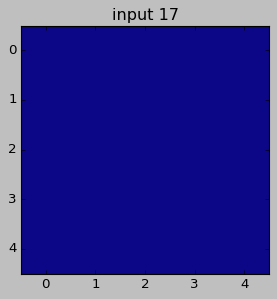

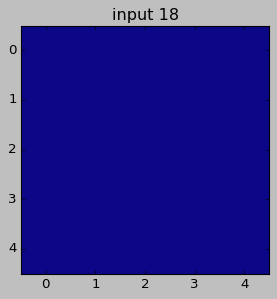

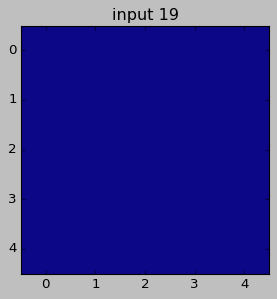

epoch [1/5000], loss:5052803072.0000


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


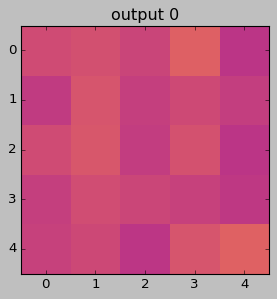

epoch [501/5000], loss:567397824.0000


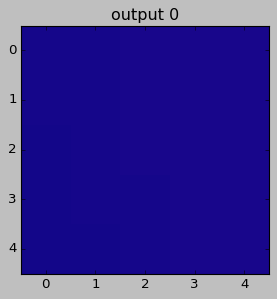

epoch [1001/5000], loss:336113280.0000


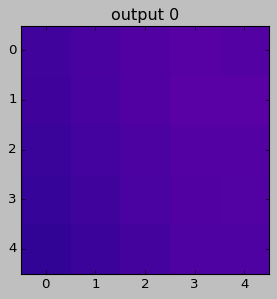

epoch [1501/5000], loss:332178688.0000


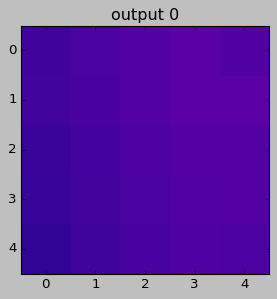

epoch [2001/5000], loss:261387040.0000


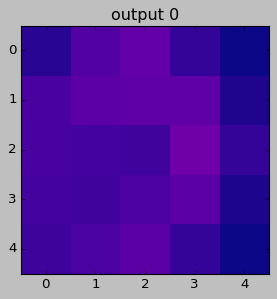

epoch [2501/5000], loss:74763936.0000


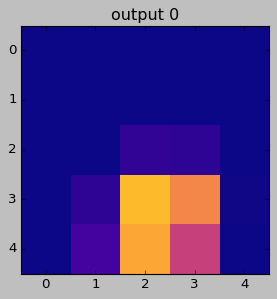

epoch [3001/5000], loss:14592970.0000


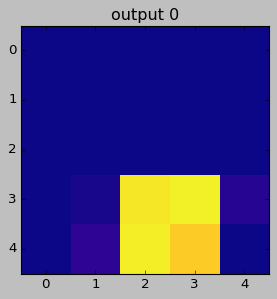

epoch [3501/5000], loss:6108552.5000


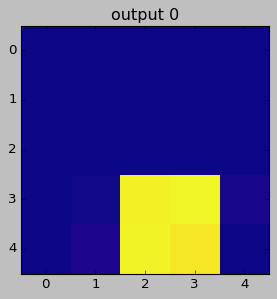

epoch [4001/5000], loss:3407716.7500


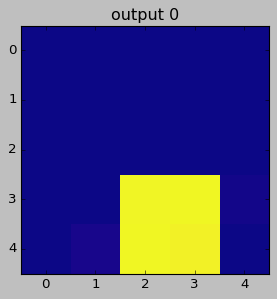

epoch [4501/5000], loss:2170109.2500


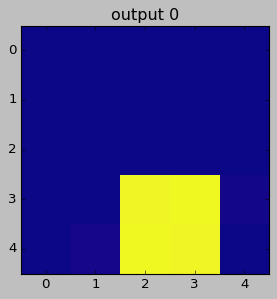

epoch [5001/5000], loss:1455862.5000


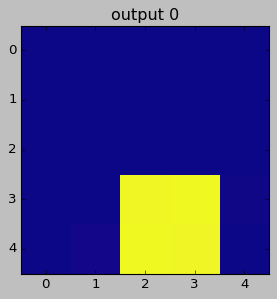

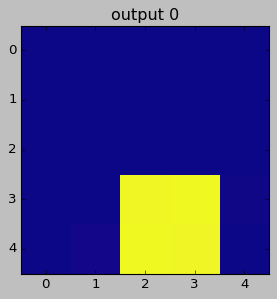

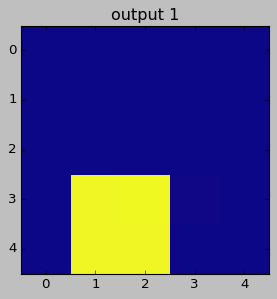

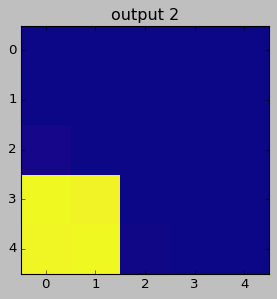

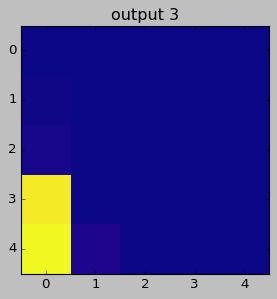

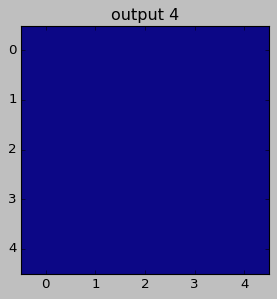

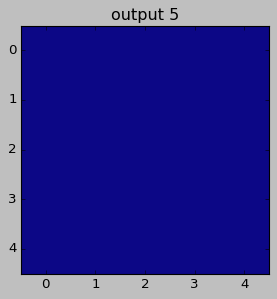

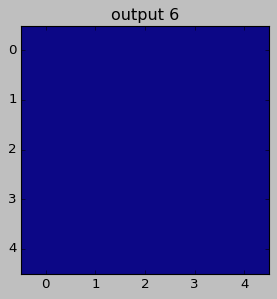

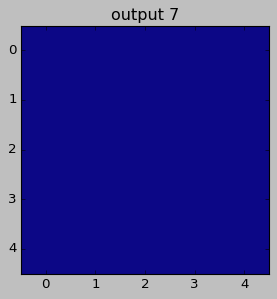

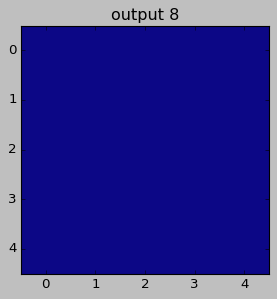

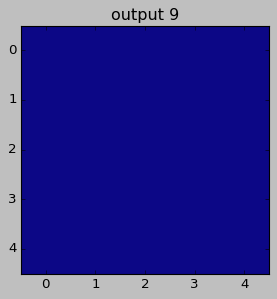

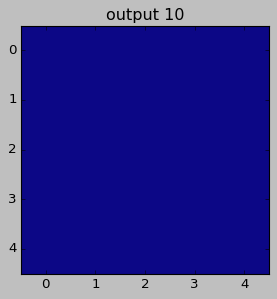

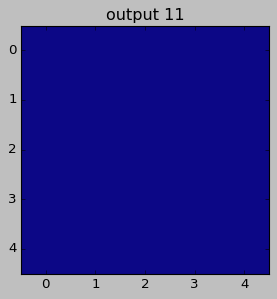

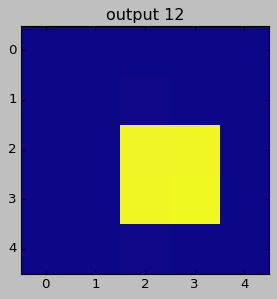

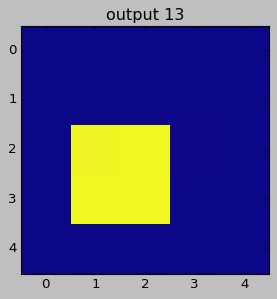

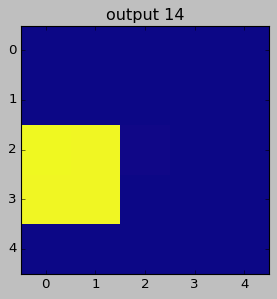

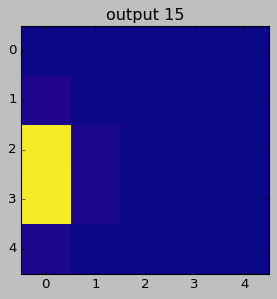

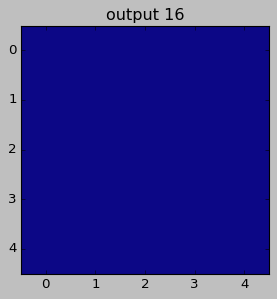

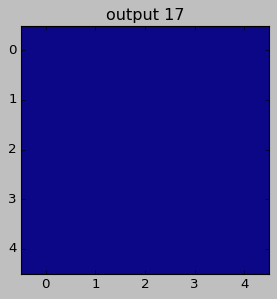

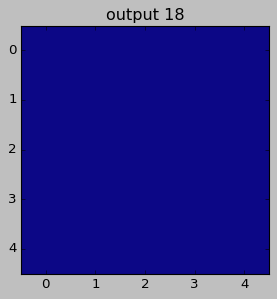

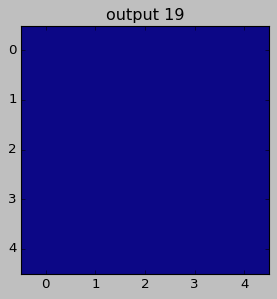

In [91]:
image_height = image_width = image_size = 16
image_count = 20
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

images = generate_bouncing_pixel(image_height, image_width, count=image_count)

input = []
kernel_size = 5
stride = 1
for i in range(image_count):
  for x in range(0, image_height - kernel_size + 1, stride):
    for y in range(0, image_width - kernel_size + 1, stride):
      # print(f"{x}, {y} - {x + kernel_size}, {y + kernel_size}")
      input.append(images[i, x:x+kernel_size, y:y+kernel_size])

input = torch.stack(input).float()
input = input.view(input.shape[0], -1).to(device)
input_size = input.shape[0]
print(input.shape)

feature_count = 4

for i in range(20): #range(input_size):
  show_image(input[i].view(kernel_size, kernel_size), vmin=0, vmax=1, title=f"input {i}")

network = Network(kernel_size, kernel_size, feature_count).to(device)

decoded, mu, logvar, z = network.train(input, num_epochs=5000)

for i in range(20): #range(input_size):
  show_image(decoded[i].detach().view(kernel_size, kernel_size), vmin=0, vmax=1, title=f"output {i}")


In [0]:
# import os
# import glob

# files = glob.glob('./*.pt')
# for f in files:
#     os.remove(f)

mu torch.Size([2880, 4])
input_size 2880
mu.shape torch.Size([2880, 4])
a 2
a 2


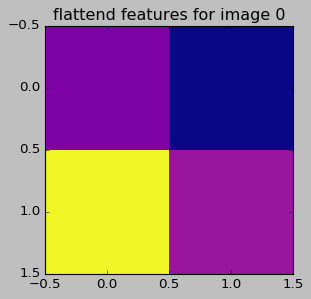

unflatten 1:  torch.Size([2880, 2, 2])
unflatten 2:  torch.Size([2880, 1, 2, 1, 2])
unflatten 3:  torch.Size([2880, 1, 1, 2, 2])
unflatten 4:  torch.Size([2880, 4])


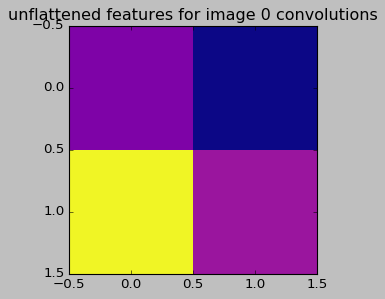

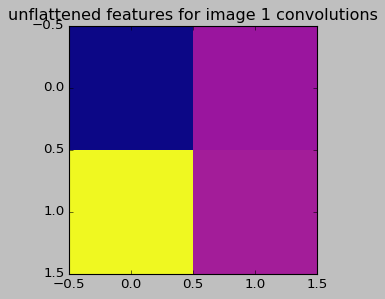

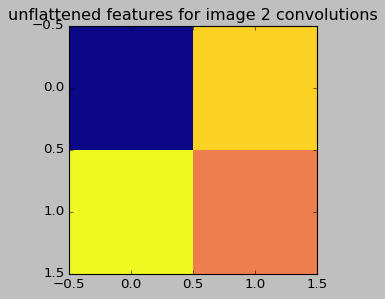

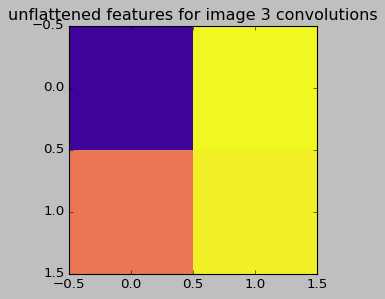

decoded torch.Size([2880, 25])


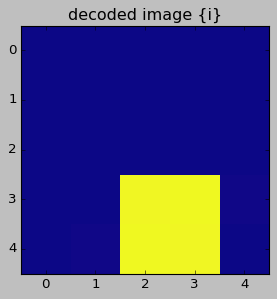

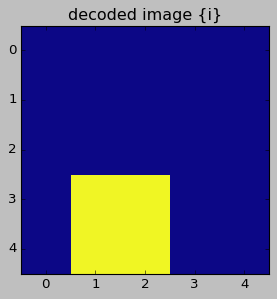

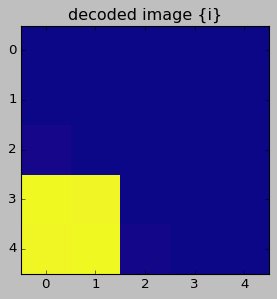

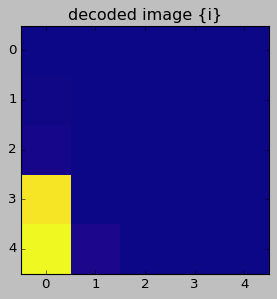

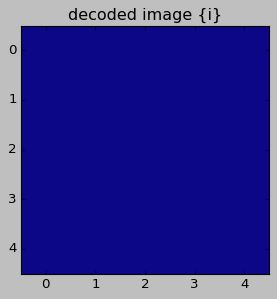

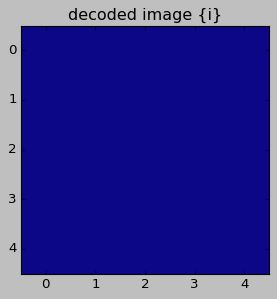

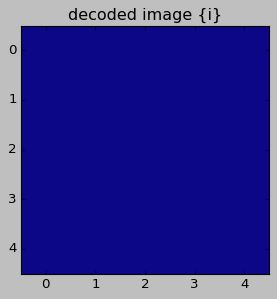

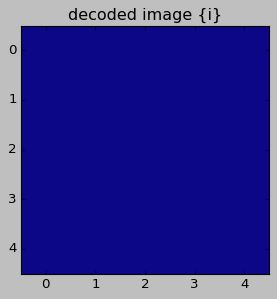

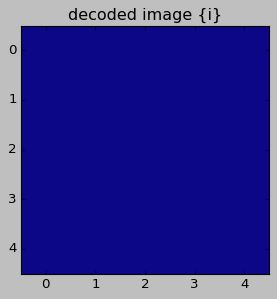

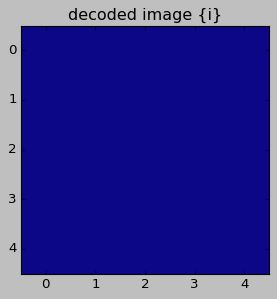

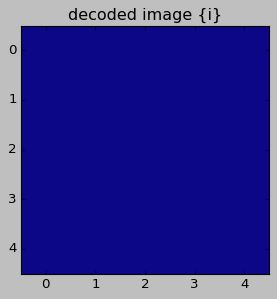

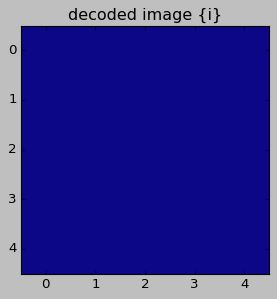

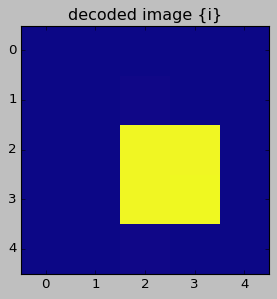

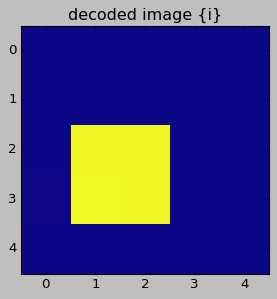

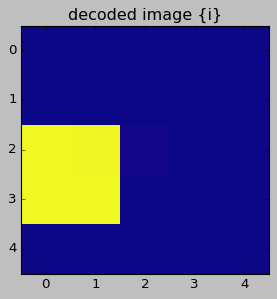

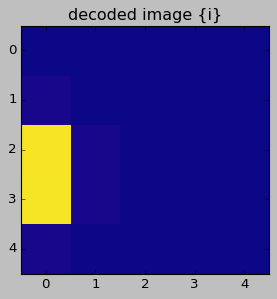

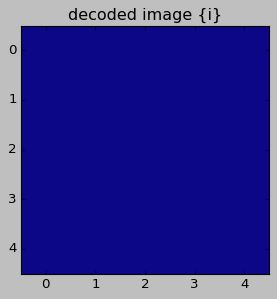

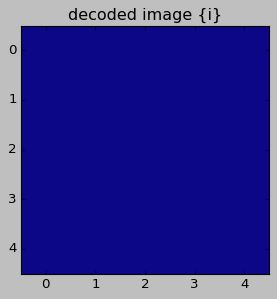

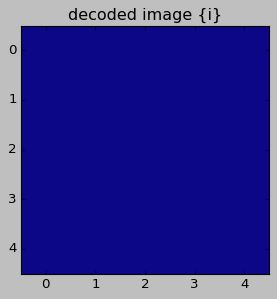

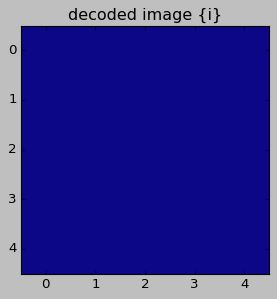

In [92]:
# decoded, mu, logvar, z = network.train(input, num_epochs=100)

# print(mu.shape)
# print(mu)
# print("------------")

# for i in range(4):
#   show_image(mu[i].detach().view(2, 2), vmin=0, vmax=1, title=f"features for image 0 convolutions")

def flatten_features(mu, input_size):
  a = int(mu.shape[1] ** 0.5)
  print("mu.shape", mu.shape)
  print("a", a)
  w = int(int(mu.shape[0] / input_size) ** 0.5)
  mu1 = mu.view(input_size, w, w, a , a)
  mu1 = mu1.permute(0, 1, 3, 2, 4)
  s = mu1.shape
  mu1 = mu1.contiguous().view(s[0], s[1] * s[2], s[3] * s[4])
  return mu1, a

def unflatten_features(h1, a):
  s = h1.shape
  print("unflatten 1: ", s)
  h = h1.view(s[0], int(s[1] / a), a, int(s[2] / a), a)
  print("unflatten 2: ", h.shape)
  h = h.permute(0, 1, 3, 2, 4)
  print("unflatten 3: ", h.shape)
  
  s = h.shape
  h = h.contiguous().view(s[0] * s[1] * s[2], s[3] * s[4])
  print("unflatten 4: ", h.shape)

  return h

def decode(unflattened_mu, logvar, network):
  return network.vae.decode_features(unflattened_mu, logvar)
  
print("mu", mu.shape)
print("input_size", input_size)
h1, a = flatten_features(mu, input_size)
print("a", a)
# print(mu)
# print("------------")
for i in range(1):
  show_image(h1[i].detach(), vmin=0, vmax=1, title=f"flattend features for image {i}")

unflattened_mu = unflatten_features(h1, a)
for i in range(4):
  show_image(unflattened_mu[i].detach().view(2, 2), vmin=0, vmax=1, title=f"unflattened features for image {i} convolutions")

decoded, _ = decode(unflattened_mu, torch.ones(unflattened_mu.size()).mul(-10).to(device), network)
print("decoded", decoded.shape)

for i in range(20):
  show_image(decoded[i].detach().view(kernel_size, kernel_size), vmin=0, vmax=1, title="decoded image {i}")
  
  
# print(logvar.exp())
# print(z)
# decoded = network.vae.decode(torch.as_tensor(z[6:7,:]).to(device))
# show_image(decoded[0].detach().view(input_height, input_width), vmin=0, vmax=1)



# TODO!!!
# h1 flattended feature map (image count, conv stpes * features, conv steps * features) ==> unflattened

decoded.shape torch.Size([2880, 25])
------------------------- IMAGE 0 --------------------------


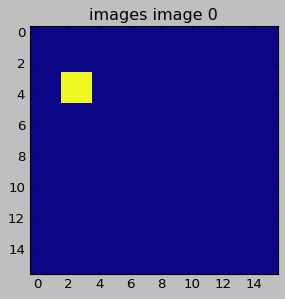

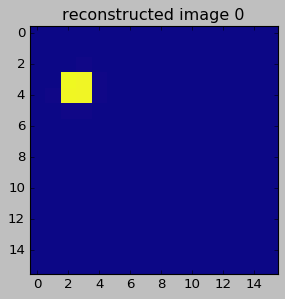

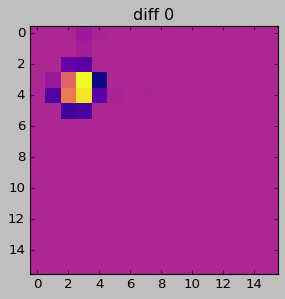

------------------------- IMAGE 1 --------------------------


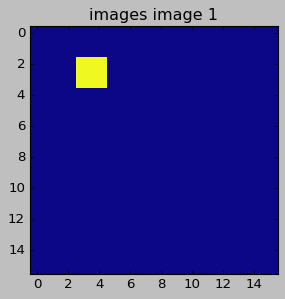

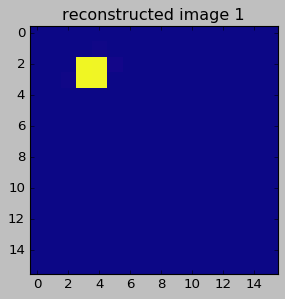

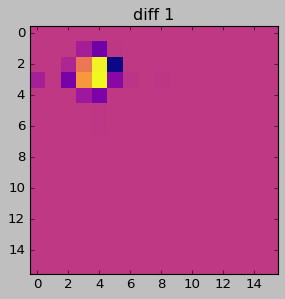

------------------------- IMAGE 2 --------------------------


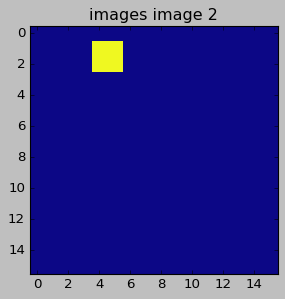

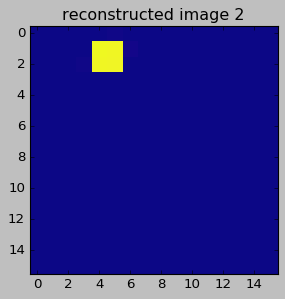

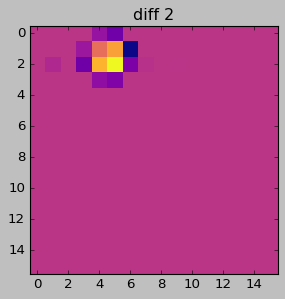

------------------------- IMAGE 3 --------------------------


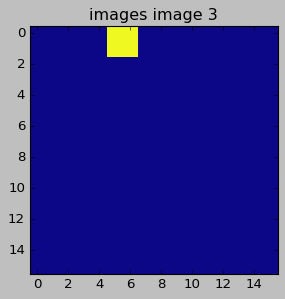

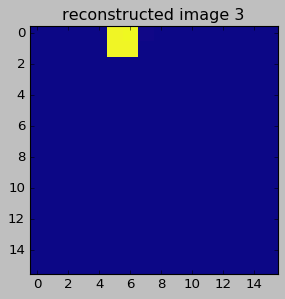

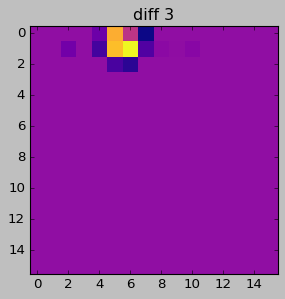

------------------------- IMAGE 4 --------------------------


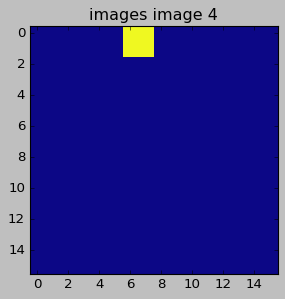

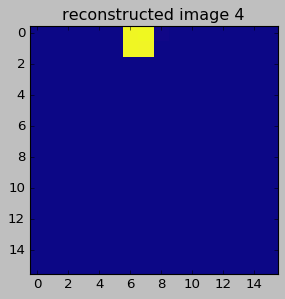

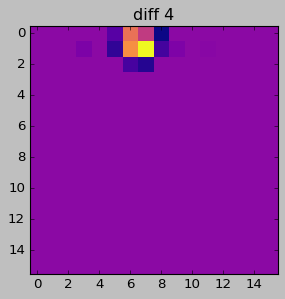

------------------------- IMAGE 5 --------------------------


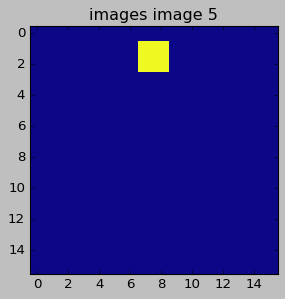

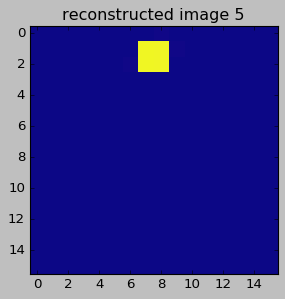

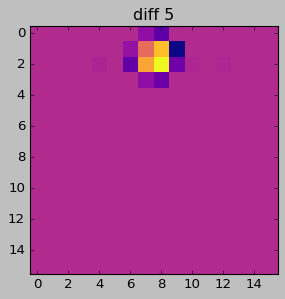

------------------------- IMAGE 6 --------------------------


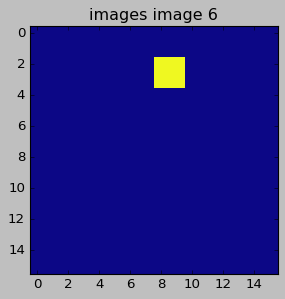

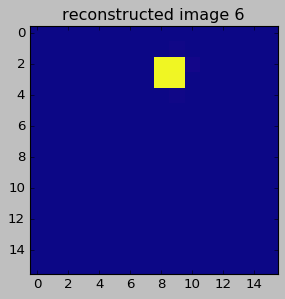

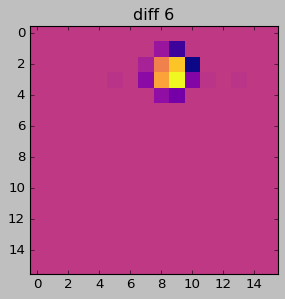

------------------------- IMAGE 7 --------------------------


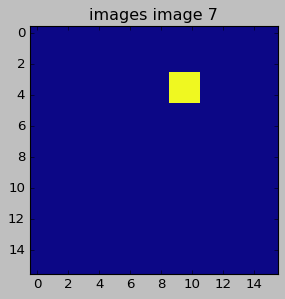

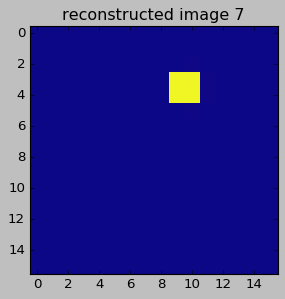

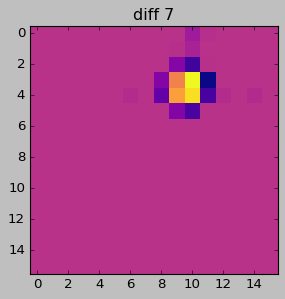

------------------------- IMAGE 8 --------------------------


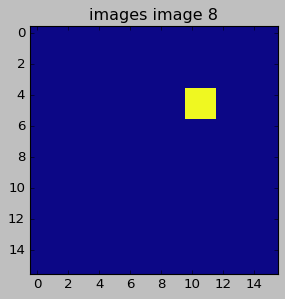

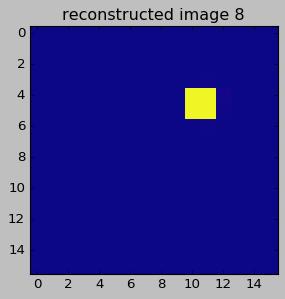

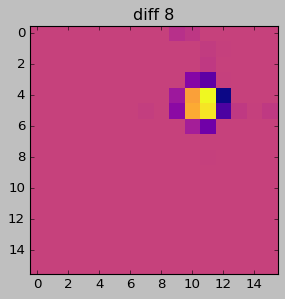

------------------------- IMAGE 9 --------------------------


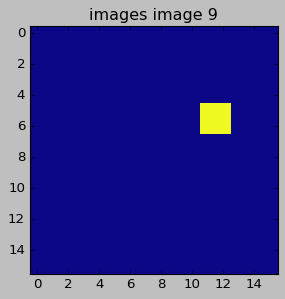

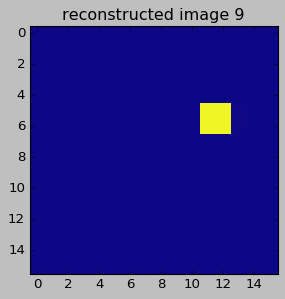

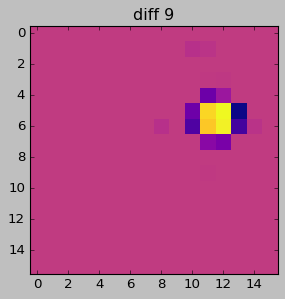

------------------------- IMAGE 10 --------------------------


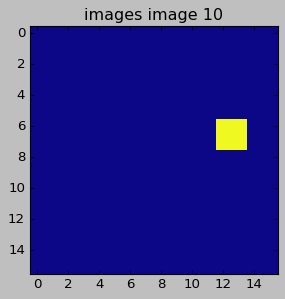

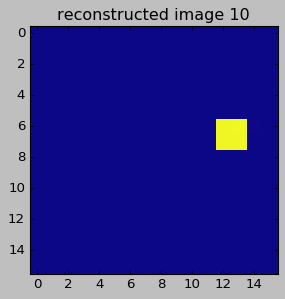

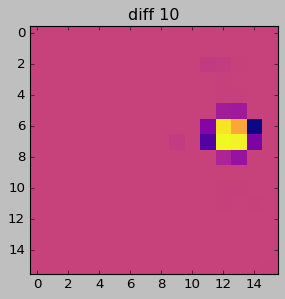

------------------------- IMAGE 11 --------------------------


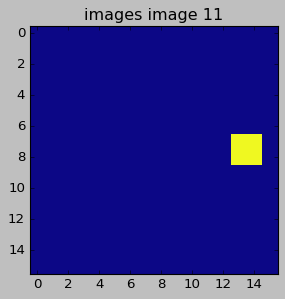

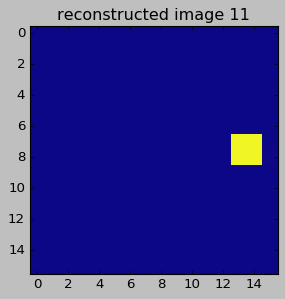

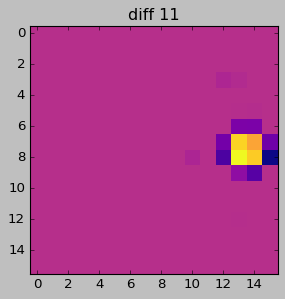

------------------------- IMAGE 12 --------------------------


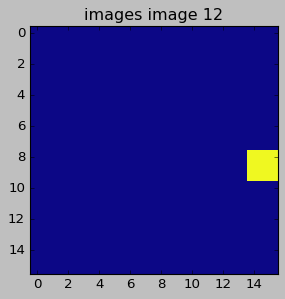

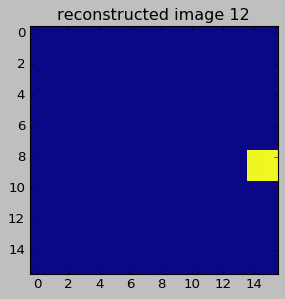

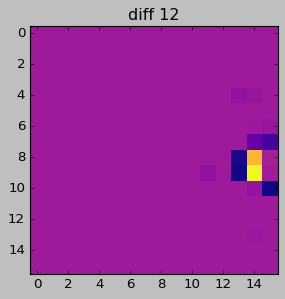

------------------------- IMAGE 13 --------------------------


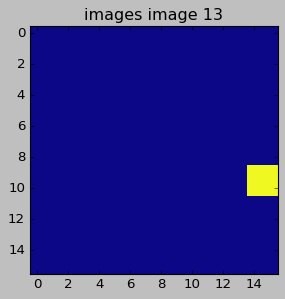

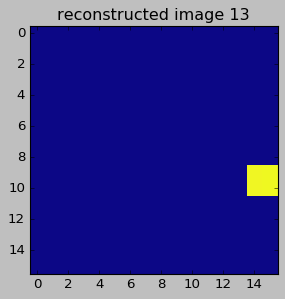

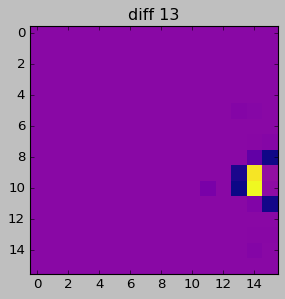

------------------------- IMAGE 14 --------------------------


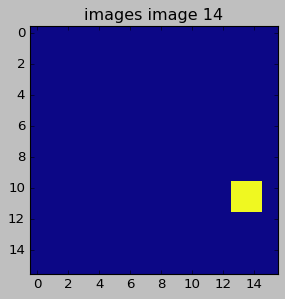

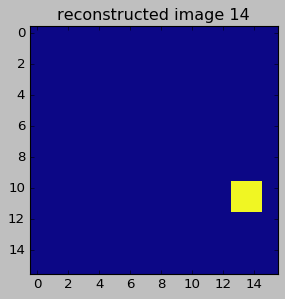

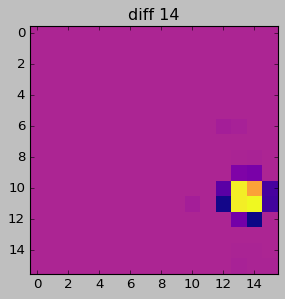

------------------------- IMAGE 15 --------------------------


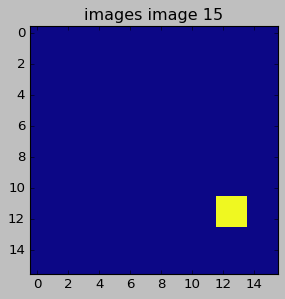

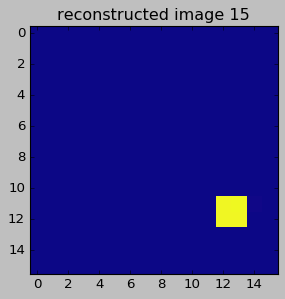

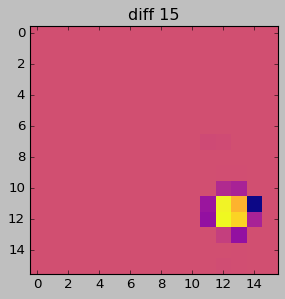

------------------------- IMAGE 16 --------------------------


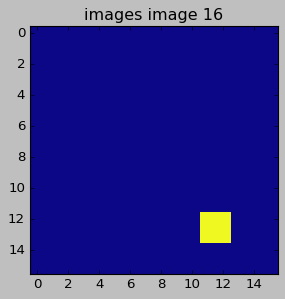

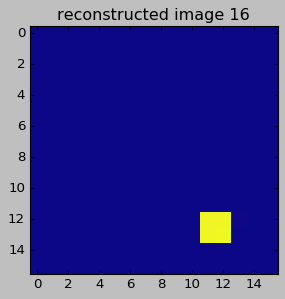

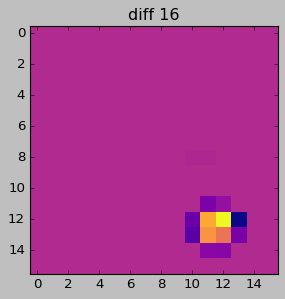

------------------------- IMAGE 17 --------------------------


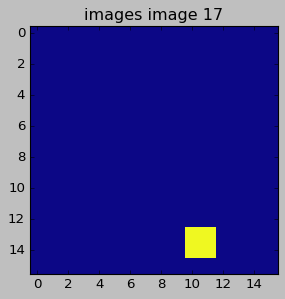

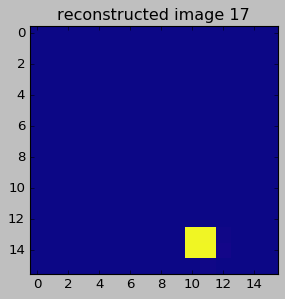

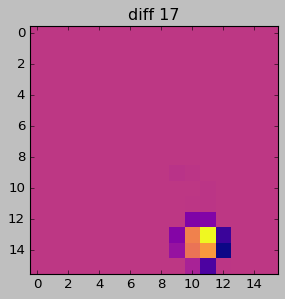

------------------------- IMAGE 18 --------------------------


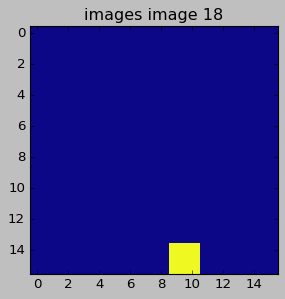

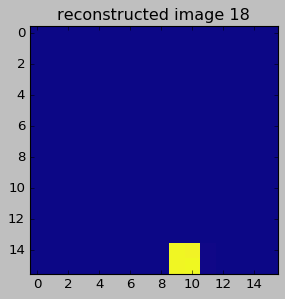

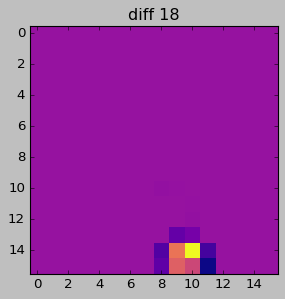

------------------------- IMAGE 19 --------------------------


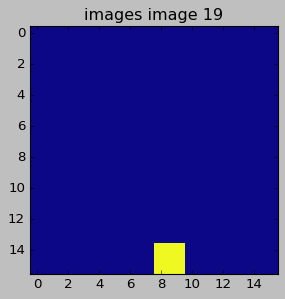

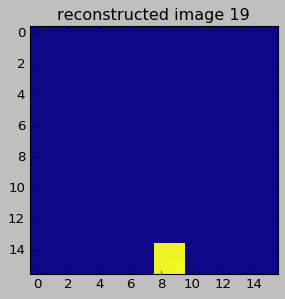

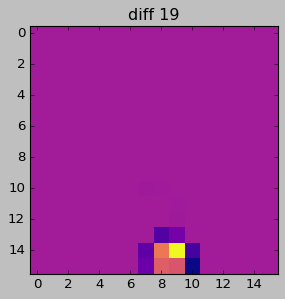

In [93]:
def convolve(image_width, image_height, kernel_size, stride):
  convolutions = []
  for x in range(0, image_width - kernel_size + 1, stride):
    for y in range(0, image_height - kernel_size + 1, stride):
      convolutions.append([y, x, y + kernel_size - 1, x + kernel_size - 1])

  return convolutions

def deconvolve(decoded, image_count, image_width, image_height, kernel_size, stride):
  print("decoded.shape", decoded.shape)
  if len(decoded.shape) == 2:
    decoded = decoded.view(image_count, int(decoded.shape[0] / image_count), kernel_size, kernel_size)

  # decoded is now (image count, convolutions, kernel size, kernel size)
  #print("decoded.shape", decoded.shape)

  convolutions = convolve(image_width, image_height, kernel_size, stride)
  assert len(convolutions) == decoded.shape[1]
  
  buffer = torch.zeros((image_count, image_width, image_height)).to(device)
  #print("buffer", buffer.shape)
  
  for i in range(image_count):
    #if i == 0:
    #  print("decoded[i]", decoded[i])

    for x in range(image_width):
      for y in range(image_height):
        values = []
        for c in range(len(convolutions)):
          convolution = convolutions[c]
          if x >= convolution[0] and x <= convolution[2] and y >= convolution[1] and y <= convolution[3]:
            value = decoded[i, c, y - convolution[1], x - convolution[0]]
            values.append(value.item())
            #if i == 0 and x == 3 and y == 3:
            #  print(f"x {x}, y {y}, convolution {convolution}")
            #  print(f"[{x - convolution[0]}, {y - convolution[1]}]", value)
            
        #if i == 0 and x == 3 and y == 3:
        # print(f"i {i}, x {x}, y {y}")
        # print("values", values)
        if len(values) > 0:
          value = np.average(values)
          #print("value", value)
          buffer[i, y, x] = value
          
  return buffer

restored_images = deconvolve(decoded, image_count, image_width, image_height, kernel_size, stride)
for i in range(20):
  print(f"------------------------- IMAGE {i} --------------------------")
  show_image(images[i].detach(), vmin=0, vmax=1, title=f"images image {i}")
  show_image(restored_images[i].detach(), vmin=0, vmax=1, title=f"reconstructed image {i}")
  show_image(images[i].float()-restored_images[i].detach().cpu(), title=f"diff {i}")




In [57]:
print(image_width)
convolve(image_width, image_height, kernel_size, stride)

8


[[0, 0, 4, 4],
 [1, 0, 5, 4],
 [2, 0, 6, 4],
 [0, 1, 4, 5],
 [1, 1, 5, 5],
 [2, 1, 6, 5],
 [0, 2, 4, 6],
 [1, 2, 5, 6],
 [2, 2, 6, 6]]

In [56]:
decoded = decoded.view(image_count, int(decoded.shape[0] / image_count), kernel_size, kernel_size)
decoded.shape

torch.Size([20, 16, 5, 5])